In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Use this cell to regroup all your imports
from sklearn.pipeline import Pipeline,  make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer,make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

#models
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#esemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# House Prices Kaggle Competition

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

The goal to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

Metric: Root-Mean-Squared-Error (RMSE)

I submitted online an answer to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Load data

Load the train dataset in a DataFrame `data` and create your `X` and `y`.

In [3]:
data = pd.read_csv("data/train.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
X = data.drop(columns=['SalePrice','Id'])
y = data.SalePrice
X.shape

(1460, 79)

## Baseline

### Initial feature overview

79 features is too much to deal with for a first baseline pipeline! Checking their `dtype` first:

In [5]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

Analysing categorical features:

In [6]:
feat_categorical_nunique = X.select_dtypes(include=object).nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

If I use `OneHotEncode` all categorical features, the feature matrix would become pretty big with almost 300 (highly correlated) features for only 1400 observations. Ideally, the model should have 50-100 features max (Ref [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

Strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to the model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

<AxesSubplot:>

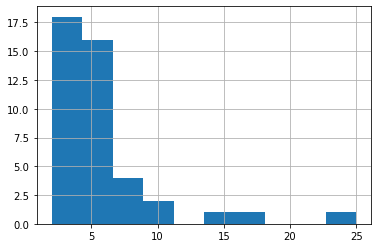

In [7]:
feat_categorical_nunique.hist()

As a start, I'm simply removing all features that have **7 unique values or more**, and one-hot-encode every others.

In [8]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique<7].index)
feat_categorical_small

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

## Preprocessing pipeline

---
Categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


Numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 

In [9]:
#Categorical pipeline
pipe_cat = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                         OneHotEncoder(handle_unknown="ignore"))
# Numerical pipeline
pipe_num = make_pipeline(SimpleImputer(), MinMaxScaler())

In [10]:
preproc_baseline = make_column_transformer(
    (pipe_cat, feat_categorical_small),
    (pipe_num, make_column_selector(dtype_include=["int64", "float64"])), remainder = 'drop')

In [11]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQua...
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d083d4850>)])

❓ Look at the **shape** of your preprocessed dataframe.

In [12]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

## Model baseline

In [18]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQu...
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d083d4850>)])),
                ('ridge', Ridge())])

Creating the scorer rmsle and a negative one rmsle_neg for the GridSearch to _maximize_

In [19]:
# This is the metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is the score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

5-fold cross_validate to get a first glance at the baseline perf.

In [20]:
#Evaluate metric(s) by cross-validation and also record fit/score times. Do not confuse with cross_val_score,
#which evaluates a score
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.16642907520861672

## Predict baseline

Predict from the Kaggle `test.csv` dataset .

In [21]:
X_test = pd.read_csv("data/test.csv")
X_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [22]:
X_test_ids = X_test['Id'] # Keep ids for the submission
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

In [20]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,113256.769594


# Improving prediction

**Models**

- Linear Models: fine-tune regularization
- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?

## Preprocessing Iteration

### Ordinal Encoding


Split categorical preprocessor into:

- `preproc_ordinal` to ordinally encode **some features** of choice
- `preproc_nominal` to one hot encode the other ones

In [23]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

In [24]:
#Encode categorical features as an integer array. The input to this transformer should be an array-like of integers 
#or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal 
#integers. This results in a single column of integers (0 to n_categories - 1) per feature.

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically - get dict keys
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal] # get dict values
feat_ordinal_values_sorted

[['missing', 'Po', 'Fa', 'TA', 'Gd'],
 ['missing', 'No', 'Mn', 'Av', 'Gd'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Unf', 'RFn', 'Fin'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
 ['missing', 'Sev', 'Mod', 'Gtl'],
 ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
 ['missing', 'N', 'P', 'Y'],
 ['missing', 'Fa', 'Gd', 'Ex']]

In [25]:
#new pipeline
encoder_ordinal = OrdinalEncoder(categories=feat_ordinal_values_sorted, 
                                 dtype=np.int64, 
                                 handle_unknown='use_encoded_value', 
                                 unknown_value=-1) # Considers unknown values as worse than "missing"

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)
preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [31]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [32]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [33]:
preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d1b393c10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categor...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [34]:
preproc.fit_transform(X).shape #still too much, go to statistical feature selection

(1460, 216)

### Target engineering

Transforming target to log as we are asked to minimize the RMS**L**E.
- Check-out historgram of your target `y`. Normally distributed variables should be easier to predict with linear models. 
- Create `y_log` and new performance metrics

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

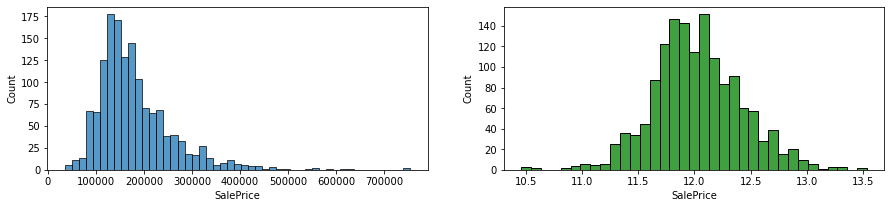

In [35]:
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green')

In [36]:
#as our target is log, we don't need to use log metric anymore:
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Statistical Feature Selection

The goal is to remove the least interesting features, to limit overfitting and shorten training time.

#### Univariate feature selection based on relationship with target `y`
- This will filter-out features that individually least explain the target

In [37]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d1b3b1a00>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f9d1adf3040>))])

In [39]:
preproc.fit_transform(X,y_log).shape #much better now

(1460, 108)

## Models Iteration

### Linear Model

In [40]:
#normal ridge
model1 = Ridge()
ridge_pipe = make_pipeline(preproc, model1)
cross_val_score(ridge_pipe, X, y_log, cv=5, scoring=rmse).mean()

0.13992119440355438

In [41]:
# GridSearch the Ridge regularization
param_grid =  {'ridge__alpha': np.linspace(0.5,2,num=20)}
search_ridge = GridSearchCV(ridge_pipe, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

search_ridge.fit(X, y_log);
print(search_ridge.best_params_)
search_ridge.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'ridge__alpha': 0.6578947368421053}


-0.13856741836839087

### KNN

In [42]:
#normal KNN
model2 = KNeighborsRegressor()
KNN_pipe = make_pipeline(preproc, model2)
cross_val_score(KNN_pipe, X, y_log, cv=5, scoring=rmse).mean()

0.20120671959058187

In [43]:
# GridSearch the KNN
param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
search_knn = GridSearchCV(KNN_pipe, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

search_knn.fit(X, y_log);
print(search_knn.best_params_)
search_knn.best_score_

Fitting 3 folds for each of 11 candidates, totalling 33 fits
{'kneighborsregressor__n_neighbors': 6}


-0.20443050208032662

### SVM

The free parameters in the model are C and epsilon

- Cfloat, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- epsilonfloat, default=0.1
Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [46]:
#normal SVM linear kernel
model31 = SVR(C=1, epsilon=0.05) #rbf is the standard
SVM_pipe31 = make_pipeline(preproc, model31)
cross_val_score(SVM_pipe, X, y_log, cv=5, scoring=rmse).mean()

0.1386922705124518

In [47]:
#normal SVM linear kernel
model32 = SVR(kernel='linear', C=1, epsilon=0.05)
SVM_pipe32 = make_pipeline(preproc, model32)
cross_val_score(SVM_pipe, X, y_log, cv=5, scoring=rmse).mean()

0.14004609046090305

In [48]:
# GridSearch
param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
              'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
               #'svr__coef0': [0.0, 0.1, 0.5,1],
              }
search_svm_rbf = GridSearchCV(SVM_pipe31, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

search_svm_rbf.fit(X, y_log);
svm_rbf_best = search_svm_rbf.best_estimator_
print(search_svm_rbf.best_params_)
search_svm_rbf.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'svr__C': 1, 'svr__epsilon': 0.05}


-0.12658482140982788

### Decision Trees

In [44]:
#Esemble decision trees
model4 = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
trees_pipe = make_pipeline(preproc, model4)
score = cross_val_score(trees_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.010003816656193959


0.18894277772061632

### Random Forest

In [45]:
#Esemble random forest
model5 = RandomForestRegressor(max_depth=50, min_samples_leaf=20)
forest_pipe = make_pipeline(preproc, model5)
score = cross_val_score(forest_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.006910314836349749


0.16269305426569056

### Boosting trees

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

The base estimator from which the boosted ensemble is built. If None, then the base estimator is DecisionTreeRegressor initialized with max_depth=3.

In [46]:
#Esemble AdaBoost
model6 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
ada_pipe = make_pipeline(preproc, model6)
score = cross_val_score(ada_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.009481436373654008


0.14269259992291114

In [47]:
#Esemble Gradient
model7 = GradientBoostingRegressor() # n_estimators default=100
gradient_pipe = make_pipeline(preproc, model7)
score = cross_val_score(gradient_pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.008394730345363836


0.1273701008905757

### Stacking

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

In [48]:
#train best algorithms and agg the predictions

catboost = CatBoostRegressor()
xgboost = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge(alpha= 0.9736842105263157)
SVM = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model8 = StackingRegressor(
    estimators=[("gboost", gboost),("adaboost", adaboost),("ridge", ridge), 
                ("svm", SVM), ("cat", catboost), ("XGB", xgboost)],
    
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model8)
score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.011400593406509507


0.1204809941136159

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

In [49]:
#train best algorithms and agg the predictions

catboost = CatBoostRegressor()
xgboost = XGBRegressor()
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
ridge = Ridge(alpha= 0.9736842105263157)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
SVM = SVR(C=1, epsilon=0.05)

model9 = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm", SVM),
                 ("cat", catboost),("XGB", xgboost)],
    weights = [1,1,1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_voting = make_pipeline(preproc, model9)
score = cross_val_score(pipe_voting, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.010096641301283911


0.12113817504798022

# Final submission

As the stacking model obtained the best score, this is the model I choose to use in my prediction. 

In [50]:
# Predict y_pred_baseline
pipe_stacking.fit(X,y)
y_pred_final = pipe_stacking.predict(X_test)
y_pred_final

array([120683.3977544 , 157306.27869221, 182161.73152291, ...,
       167807.41949285, 119543.44121939, 223786.39132453])

In [51]:
results = pd.concat([X_test_ids, pd.Series(y_pred_final, name="SalePrice")], axis=1)
results.head(10)

,Id,SalePrice
0,1461,120683.397754
1,1462,157306.278692
2,1463,182161.731523
3,1464,185515.844961
4,1465,198114.124763
5,1466,170236.683439
6,1467,167810.511288
7,1468,159803.688478
8,1469,185833.488487
9,1470,123228.532113


In [66]:
results.to_csv('data/submission_baseline.csv', header=True, index=False)